Get Dynamic Word Embeddings

In [1]:
import numpy as np
import json
from pprint import pprint
from scipy.spatial.distance import pdist
# word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
years = range(2013,2023)
dir = "output/embeddings/word2vec_drug_"

models = []
for year in years:
    models.append(Word2Vec.load(dir+str(year)+".model"))

### From "Diachronic Word Embeddings Reveal Statistical Lawso f Semantic Change" by Jurafsky et al. to explore semantic changes of target words over time

`Low-dimensional embeddings will not be naturally aligned due to the non-unique nature of the SVD and the stochastic nature of SGNS. In particular, both these methods may result in arbitrary orthogonal transformations, which do not affect pairwise cosine-similarities within-years but will preclude comparison of the same word across time.`

We use orthogonal Procrustes to align the learned low-dimensional embeddings. Defining W(t) ∈ Rd×|V| as the matrix of word embeddings learned at year t, we align across time-periods while preserving cosine similarities by optimizing:

2. Alignment

In [3]:
from scipy.linalg import orthogonal_procrustes

# test
orthogonal_procrustes(models[0].wv.vectors, models[1].wv.vectors)
# second value in the tuple the sum of A.T @ B

(array([[ 9.7583538e-01, -2.9933630e-02, -9.6229631e-03, ...,
          1.2366860e-03,  1.1423454e-02, -7.9603968e-03],
        [ 3.8002558e-02,  9.7058749e-01,  1.7001515e-02, ...,
          8.6021191e-03, -2.1651940e-02, -1.2767159e-02],
        [ 1.1018273e-02, -1.0034653e-02,  9.8828554e-01, ...,
         -1.0459967e-02,  8.5425153e-03, -5.0058328e-03],
        ...,
        [-1.7443834e-03,  1.5867915e-02,  5.9310133e-03, ...,
          9.7423583e-01, -4.3327161e-03,  1.2995080e-02],
        [-1.0428051e-02, -5.7214238e-03,  8.7935344e-04, ...,
          2.1842772e-02,  9.7027296e-01, -5.3401180e-03],
        [ 2.2851206e-02,  1.4900244e-02,  1.0679573e-04, ...,
         -1.6361618e-02,  1.4998628e-02,  9.8378563e-01]], dtype=float32),
 45978.137)

In [9]:
matrices = [embedding.wv.vectors for embedding in models]
# np.array(matrices).shape

In [10]:
# stack the matrices
stacked_matrices = np.stack(matrices, axis=0)

In [4]:
# align the embeddings using Procrustes
def align_embeddings(embeddings):
    # Get the embedding matrices
    matrices = np.array(matrices)

    # Align the embeddings
    aligned_array,_ = orthogonal_procrustes(matrices[0], matrices[1])
    # aligned_matrices = [aligned[1]]  # Initialize with the first aligned matrix

    # Iterate over the remaining embeddings and align them with the previous aligned matrix
    for i in range(2, len(matrices)):
        aligned_embedding, _ = orthogonal_procrustes(matrices[i], aligned_array)
        aligned_array = aligned_embedding

    # Return the aligned embeddings as a list
    aligned_embeddings = aligned_array.tolist()
    # Return the aligned embedding matrices
    return aligned_embeddings


In [ ]:
# aligned_embeddings = align_embeddings(models)

# FUNCTION DOES NOT WORK : THE FIRST TWO MATRICES GET ALIGNED BUT REDUCED TO 300X300 - HOWEVER ALIGNMENT 
# PRODUCES AN ERROR WHEN THE THIRD MATRIX (10000X300) IS ALIGNED WITH THE 300X300 MATRIX

problem: aligning the matrices using orthogonal Procrustes requires the matrices to be of the same size. However, the number of words in the vocabulary changes over time. We solve this problem by aligning the matrices of the top 10,000 words in each time period. We could also remove words that are not present in at least 3 time periods.

1. compute cosine distance between word vectors for each year 
2. compute average cosine distance between word vectors for each year
3. compute average cosine distance between word vectors for each year and the previous year
4. compute average cosine distance between word vectors for each year and the first year

In [39]:
def print_similar(self, word, num):
    print("Similar to " + word + ":")
    similar = self.wv.most_similar(word, topn=num)
    for word in similar:
        print(word)
    # return dictionary for plotting
    return dict(similar)

# get the most similar words for each year
similar_words = []
for i in range(len(years)):
    similar_words.append(print_similar(models[i], "opioid", 10))



Similar to opioid:
('united', 0.9998718500137329)
('schools', 0.9998494982719421)
('addiction', 0.9998436570167542)
('increased', 0.9998312592506409)
('taken', 0.9998275637626648)
('help', 0.9998238682746887)
('borough', 0.9998204708099365)
('use', 0.9998194575309753)
('emergency', 0.9998182058334351)
('large', 0.999817967414856)
Similar to opioid:
('approved', 0.9996926188468933)
('state', 0.9995952248573303)
('bill', 0.9995729327201843)
('kenneys', 0.9994878768920898)
('allow', 0.9994849562644958)
('states', 0.9994767308235168)
('rate', 0.9994271397590637)
('enforcement', 0.9993909001350403)
('kenney', 0.9993343949317932)
('administer', 0.9993057250976562)
Similar to opioid:
('national', 0.9998816847801208)
('including', 0.9998791813850403)
('2012', 0.9998770356178284)
('2011', 0.9998743534088135)
('president', 0.9998735785484314)
('treatment', 0.9998732209205627)
('10', 0.9998727440834045)
('alcohol', 0.9998688697814941)
('months', 0.999862551689148)
('legal', 0.9998574256896973)
Si

In [ ]:
# output
# visualization of a word over time
# x-axis is year
# y-axis is a one-dimensional projection of the word embedding using t-SNE

# get the word embeddings for each year
# get the words
seed_word = "heroin"
# words = ["opioid","medication", "treatment", "methadone", "cannabis", "marijuana", "therapy", "pain", "addiction"]

# get the embeddings
embeddings = []
top_words = []
for model in models:
    embeddings.append(model.wv[seed_word])
    # get top 5 most similar words
    top_words.append([word for word, _ in model.wv.most_similar(seed_word, topn=5)])

# get the t-SNE embeddings
from sklearn.manifold import TSNE

tsne_embeddings = []
for embedding in embeddings:
    # reshape the embedding
    embedding = embedding.reshape(1, -1)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    tsne_embeddings.append(tsne.fit_transform(embedding))

# plot the embeddings
import matplotlib.pyplot as plt

# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years, tsne_embeddings, marker="o")
# label the most similar word
for i in range(len(years)):
    ax.annotate(top_words[i], (years[i], tsne_embeddings[i]))
ax.set_title("t-SNE Embeddings for the Word 'Opioid' Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("t-SNE Embedding")




---
Folling Dynmaic Word Embedding paper

In [45]:
# A natural extension of the static word embedding intuition is to use this matrix factorization technique on each time slice Dt separately. 
# Specifically, for each time slice t, we define the w, c-th entry of positive PMI matrix (PPMI(t, L)) as

# ppmi us max of 0 and PMI
# ppmi = max(0, np.log(p_ij) - np.log(k_ij))

# enforce alignment
# 1. factorize each time slice separately
# 2. align using local linear mapping or Procrustes

# corpus
corpus = drug_articles["clean_text"].tolist()
# remove word with fewer than 200 occurances
from gensim.corpora import Dictionary
dictionary = Dictionary(corpus)
dictionary.filter_extremes(no_below=100)
# get the corpus per year
corpus = []
for year in years:
    corpus.append(drug_articles[drug_articles["Date"].dt.year == year]["clean_text"].tolist())
    corpus[-1] = [dictionary.doc2bow(text) for text in corpus[-1]]


In [48]:


# compute co-occurence matrix for each year
from gensim.matutils import corpus2csc
from scipy.sparse import csc_matrix

# get the co-occurence matrix for each year
co_occurence_matrices = []
for i in range(len(years)):
    # get the co-occurence matrix
    co_occurence_matrix = corpus2csc(corpus[i], num_terms=len(dictionary))
    # convert to sparse matrix
    co_occurence_matrix = csc_matrix(co_occurence_matrix)
    # append to the list
    co_occurence_matrices.append(co_occurence_matrix)

   

In [49]:
# compute PPMI matrix from co-occurence matrix
from scipy.sparse import csr_matrix

# get the PPMI matrix for each year
ppmi_matrices = []
for i in range(len(years)):
    # get the co-occurence matrix
    co_occurence_matrix = co_occurence_matrices[i]
    # get the sum of the rows and columns
    sum_rows = np.array(co_occurence_matrix.sum(axis=1)).flatten()
    sum_columns = np.array(co_occurence_matrix.sum(axis=0)).flatten()
    # get the total sum
    total_sum = sum_rows.sum()
    # get the PPMI matrix
    ppmi_matrix = co_occurence_matrix.copy()
    # get the indices of the non-zero elements
    rows, cols = ppmi_matrix.nonzero()
    # get the PPMI matrix
    for row, col in zip(rows, cols):
        # get the co-occurence
        co_occurence = co_occurence_matrix[row, col]
        # get the sum of the row and column
        sum_row = sum_rows[row]
        sum_col = sum_columns[col]
        # compute the PMI
        pmi = np.log(co_occurence) + np.log(total_sum) - np.log(sum_row) - np.log(sum_col)
        # compute the PPMI
        ppmi = max(0, pmi)
        # set the value
        ppmi_matrix[row, col] = ppmi
    # append to the list
    ppmi_matrices.append(ppmi_matrix)

In [50]:
# find temporal word embedding from PPMI matrix and optimize 
# using gradient descent
# get the temporal word embedding for each year
from scipy.sparse.linalg import svds

# get the temporal word embedding for each year
temporal_word_embeddings = []
for i in range(len(years)):
    # get the PPMI matrix
    ppmi_matrix = ppmi_matrices[i]
    # get the SVD
    u, s, vt = svds(ppmi_matrix, k=300)
    # get the temporal word embedding
    temporal_word_embedding = u @ np.diag(s)
    # append to the list
    temporal_word_embeddings.append(temporal_word_embedding)

In [101]:
temporal_word_embeddings[0].shape

(2776, 300)

In [ ]:
# align the temporal word embeddings using Procrustes
def align_embeddings(embeddings):
    # Get the embedding matrices
    matrices = [embedding for embedding in embeddings]
    matrices = np.array(matrices)

    # Align the embeddings
    aligned_array,_ = orthogonal_procrustes(matrices[0], matrices[1])
    # returns a 300x300 matrix

    # Iterate over the remaining embeddings and align them with the previous aligned matrix
    # align with 
    for i in range(2, len(matrices)):
        aligned_embedding, _ = orthogonal_procrustes(matrices[i], aligned_array)
        aligned_array = aligned_embedding

    # Return the aligned embeddings as a list
    aligned_embeddings = aligned_array.tolist()
    # Return the aligned embedding matrices
    return aligned_embeddings

aligned_embeddings = align_embeddings(temporal_word_embeddings)

In [95]:
blah,_ = orthogonal_procrustes(temporal_word_embeddings[0], temporal_word_embeddings[1])

(300, 300)

In [53]:
# get distance between temporal word embeddings
from scipy.spatial.distance import pdist

# get the distance between temporal word embeddings
# seed word = opioid
distances = []
for i in range(len(years)):
    # get the temporal word embedding
    temporal_word_embedding = temporal_word_embeddings[i]
    # get the distance
    distance = pdist(temporal_word_embedding, metric="cosine")
    # append to the list
    distances.append(distance)



In [102]:
# get the 2d tsne projection for the word "opioid"
from sklearn.manifold import TSNE

# get the 2d tsne projection for the word "opioid"
word = "heroin"

# nearest_neighbors = 5
# top_words = []
word_embeddings = []
for i in range(len(years)):
    # get the temporal word embedding
    temporal_word_embedding = temporal_word_embeddings[i]
    # get the index of the word
    index = dictionary.token2id[word]
    # get the embedding
    embedding = temporal_word_embedding[index]
    # reshape the embedding
    embedding = embedding.reshape(1, -1)
    word_embeddings.append(embedding)

# combine the embeddings
embeddings = np.vstack(word_embeddings)
# get the tsne embeddings
tsne = TSNE(perplexity=30, n_components=2, init='pca', metric="cosine", n_iter=5000)
tsne_embeddings_heroin = tsne.fit_transform(embeddings)




/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [84]:
# plot the embeddings
import matplotlib.pyplot as plt

# add labels to tsne embeddings
labels = []
for i in range(len(years)):
    # year = years[i]
    # top = top_words[i]
    # labels.append(distances[i])
    lab = word + str(years[i])
    labels.append(lab)


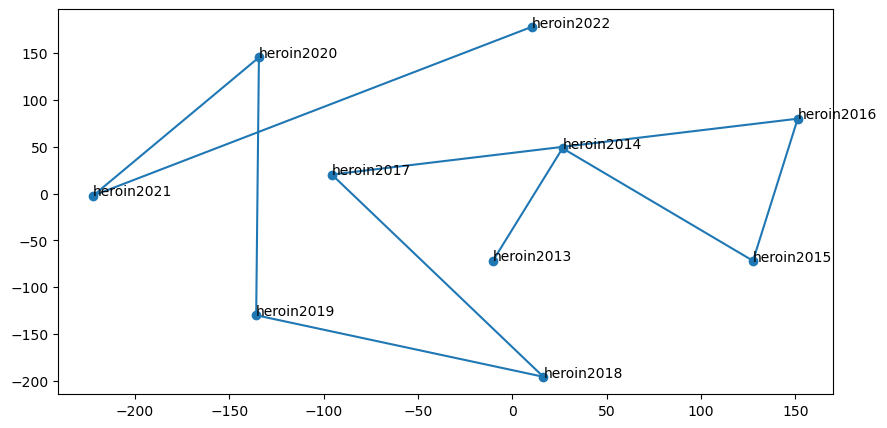

In [85]:

# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 5))
x = tsne_embeddings[:,0]
y = tsne_embeddings[:,1]
ax.plot(x, y, marker="o")
# label the most similar word
for i in range(len(years)):
    ax.annotate(labels[i], (x[i], y[i]))

# plot similar words


# ax.plot(tsne_embeddings[:,0], tsne_embeddings[:,1], marker="o", label=labels)

# legend
# ax.legend(["opioid"])

# label the most similar word
# for i in range(len(years)):
#     ax.annotate(top_words[i], (years[i], tsne_embeddings[i]))
# ax.set_title("t-SNE Embeddings for the Word 'Opioid' Over Time")
# ax.set_xlabel("Year")
# ax.set_ylabel("t-SNE Embedding")

In [103]:
# add the normalized words to the plot
# tsne of whole corpus and then plot the words on the plot
# get the tsne embeddings
tsne = TSNE(perplexity=30, n_components=2, init='pca', metric="cosine", n_iter=5000)
tsne_embeddings = tsne.fit_transform(np.vstack(temporal_word_embeddings))
# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 5))
x = tsne_embeddings[:,0]
y = tsne_embeddings[:,1]
ax.plot(x, y)
# layer the tsne embedding of the word on top
ax.scatter(tsne_embeddings_heroin[:,0], tsne_embeddings_heroin[:,1], marker="o", label=labels)



/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


KeyboardInterrupt: 

In [99]:

# Load the word embeddings for each year
embeddings = {}
for i in range(len(years)):
    embeddings[years[i]] = models[i].wv
    
# Calculate the semantic shift of "addiction" within each year
semantic_shift = []
for year in range(2013, 2022):
    if year in embeddings:
        current_embedding = embeddings[year]
        next_year_embedding = embeddings[year + 1]

        if  word in current_embedding.key_to_index and word in next_year_embedding.key_to_index:
            current_vector = current_embedding["addiction"]
            next_year_vector = next_year_embedding["addiction"]
            cosine_similarity = np.dot(current_vector, next_year_vector) / (
                np.linalg.norm(current_vector) * np.linalg.norm(next_year_vector)
            )
            semantic_shift.append((year, year + 1, cosine_similarity))

In [ ]:
  # Perform t-SNE on the word embeddings
tsne = TSNE(n_components=2, random_state=42)
embedded_vectors = {}
for year in range(2013, 2023):
    if year in embeddings:
        model = embeddings[year]
        vectors = [model[word] for word in model.key_to_index]
        embedded_vectors[year] = tsne.fit_transform(vectors)


In [107]:
embedded_vectors[2013]

(10000, 2)

IndexError: index 2013 is out of bounds for axis 0 with size 10

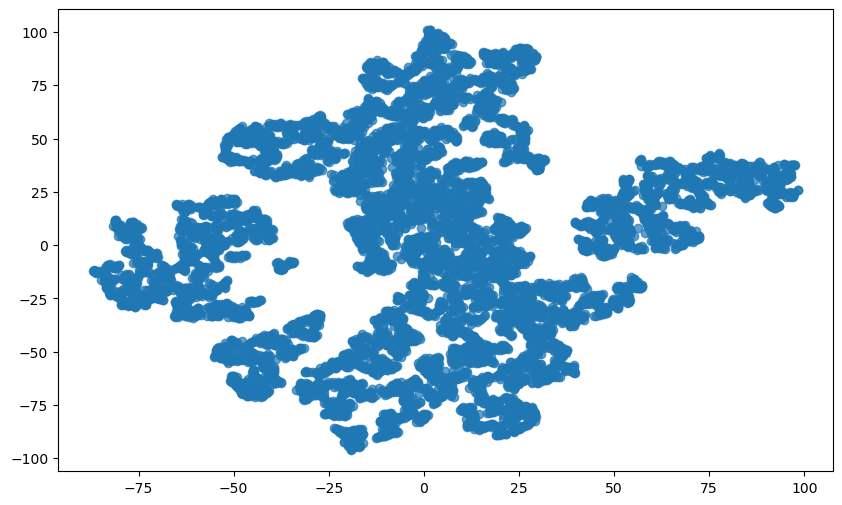

In [106]:
# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
for i, year in enumerate(range(2013, 2023)):
    if year in embedded_vectors:
        x = embedded_vectors[year][:, 0]
        y = embedded_vectors[year][:, 1]
        plt.scatter(x, y, alpha=0.7, label=year)

        # Annotate "addiction" on the plot
        if word in embeddings[year].key_to_index:
            idx = list(embeddings[year].key_to_index).index(word)
            plt.annotate(word, (x[idx], y[idx]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.legend()
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Other stuff
----

In [20]:
# use UMAP to reduce the dimensionality
import umap

reducer = umap.UMAP(n_neighbors=15, metric='cosine', random_state=42)
# fit the reducer
red_embedding = reducer.fit_transform(models[0].wv.vectors)

In [21]:
red_embedding.shape

(40458, 2)

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(models[0].wv.vectors)

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
tsne_embedding.shape

(40458, 2)

In [17]:
from sklearn.decomposition import PCA

def reduce_embeddings(embeddings):
    # Determine the maximum dimension among the word embeddings
    max_dim = max(embedding.vector_size for embedding in embeddings)
    
    # Concatenate the embeddings into a single matrix with aligned dimensions
    aligned_embeddings = []
    for embedding in embeddings:
        # Pad or truncate the embedding to match the maximum dimension
        padded_embedding = np.pad(embedding.wv.vectors, ((0, 0), (0, max_dim - embedding.vector_size)), mode='constant')
        aligned_embeddings.append(padded_embedding)
    
    combined_embeddings = np.concatenate(aligned_embeddings, axis=1)
    
    # Apply PCA with n_components set to the desired dimension (here, 10,000)
    pca = PCA(n_components=10000)
    reduced_embeddings = pca.fit_transform(combined_embeddings)
    
    return reduced_embeddings


In [ ]:
pca = PCA(n_components=10000)
reduced_embeddings = pca.fit_transform(models[0].wv.vectors)

the reduce_embeddings function first determines the maximum dimension among the word embeddings in the input list. Then, each word embedding is either padded or truncated to match the maximum dimension using np.pad. This ensures that all embeddings have the same shape along the feature axis.

The padded or truncated embeddings are stored in the aligned_embeddings list, which is then concatenated along the feature axis to create the combined_embeddings matrix. The rest of the code remains the same as before, applying PCA to reduce the dimensionality.